### Fetch Data From MongoDB

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.annotator import *
from sparknlp.base import *

In [0]:
spark = sparknlp.start()

In [0]:
database_name= "pubmed"
collection_name = "abstracts_non_small_lung_cancer"
user_name = "lsvannur"
password = "lsvannurmsds"
ip_address = "kdcluster.jyfl9.mongodb.net"
connection_string = f"mongodb+srv://{user_name}:{password}@{ip_address}/{database_name}.{collection_name}"

In [0]:
df = spark.read.format("mongo").option("uri",connection_string).load()
df = df.na.drop(subset=["article_abstract"])
df = df.dropDuplicates(['article_abstract'])
df.show()

+--------------------+--------------------+--------------------+--------------------+
|                 _id|    article_abstract|     article_authors|       article_title|
+--------------------+--------------------+--------------------+--------------------+
|{640be852eaab9943...|"Drug-targeted th...|ListElement([Dict...|DoubleSG-DTA: Dee...|
|{640be850eaab9943...|"Epidermal growth...| whether EGFR-TKI...|Effect of EGFR-TK...|
|{640be84aeaab9943...|"Thymosin alpha 1...| we believe that ...|Thymosin alpha 1 ...|
|{640be85deaab9943...|"To use bioinform...| and the potentia...|Reverse predictiv...|
|{640be84feaab9943...|"With the improve...| we discuss the e...|Treatment of adva...|
|{640be84eeaab9943...|<b></b>Treatment ...|ListElement([Dict...|Immunotherapy in ...|
|{640bd21ed40a6478...|<b>Aim:</b> To in...|ListElement([Dict...|Immune-induced pn...|
|{640be84deaab9943...|<b>Background:</b...|ListElement([Dict...|Serum circulating...|
|{640be84ceaab9943...|<b>Background:</b...|"ListElemen

In [0]:
df.count()

Out[5]: 460

##### Here the dataset is loaded from mongoDB and it contains nearly 460 medical research abstracts

#### Preprocessing text through the spacy pretrained model pipeline

1. Sentence Detecting
2. Tokenizing
3. Lemmatization
4. Tagging
5. NER

#### Using SciSpacy to do NER for Medical Text particularly DISEASE & CHEMICAL

In [0]:
!pip install spacy
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-3b5adb06-49fc-4508-bd29-20701a99d3de/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-3b5adb06-49fc-4508-bd29-20701a99d3de/bin/python -m pip install --upgrade pip' command.
     |▌                    

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 120.2 MB 99.6 MB/s 
  Created wheel for en-ner-bc5cdr-md: filename=en_ner_bc5cdr_md-0.5.1-py3-none-any.whl size=120217647 sha256=bd2daf2d2c4e0eb63e2b935524bd1bfd63e4f131d743434a429451d774dd680a
  Stored in directory: /root/.cache/pip/wheels/c5/75/0a/5db513496c30f2ef3d97870800d08d3381bdaf7949f983e3b1
Successfully built en-ner-bc5cdr-md
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-3b5adb06-49fc-4508-bd29-20701a99d3de/bin/python -m pip install --upgrade pip' command.


In [0]:
import spacy
import scispacy

### Using a pretrained NER BC5 Model for NER

In [0]:
nlpmodel = spacy.load("en_ner_bc5cdr_md")
print(f"Components of the pipeline:{nlpmodel.component_names}")
print(f"Named Entities target: {nlpmodel.get_pipe('ner').labels}")

Components of the pipeline:['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer', 'parser', 'ner']
Named Entities target: ('CHEMICAL', 'DISEASE')


#### Combine all the text from the rows into a single text data using spark sql function

In [0]:
from pyspark.sql.functions import collect_list, concat_ws

# Group the DataFrame by a article abstract column and collect the "text" column into a list
grouped_df = df.groupBy().agg(collect_list("article_abstract").alias("text_list"))

# Concatenate the "text_list" into a single string, using a space as a separator
concatenated_text = grouped_df.select(concat_ws(" ", "text_list").alias("concatenated_text")).collect()[0]["concatenated_text"]

In [0]:
alltext = concatenated_text
docx = nlpmodel(alltext) 
output = []
for token in docx:
    output.append({'text': token.text, 'lemma': token.lemma_, 'POS': token.pos_, 'Tag':token.tag_})

In [0]:
spark.createDataFrame(output).show()

+-----+-----+--------------+---------------+
|  POS|  Tag|         lemma|           text|
+-----+-----+--------------+---------------+
|  ADJ|   JJ|     epidermal|      Epidermal|
| NOUN|   NN|        growth|         growth|
| NOUN|   NN|        factor|         factor|
| NOUN|   NN|      receptor|       receptor|
|PUNCT|-LRB-|             (|              (|
| NOUN|   NN|          egfr|           EGFR|
|PUNCT|-RRB-|             )|              )|
| NOUN|  NNS|      mutation|      mutations|
| VERB|  VBP|         occur|          occur|
|  ADP|   IN|            in|             in|
|  ADV|   RB|         about|          about|
|  NUM|   CD|            50|             50|
| NOUN|   NN|             %|              %|
|  ADP|   IN|            of|             of|
| NOUN|   NN|          lung|           lung|
| NOUN|  NNS|adenocarcinoma|adenocarcinomas|
|  ADP|   IN|            in|             in|
|PROPN|  NNP|          Asia|           Asia|
|CCONJ|   CC|           and|            and|
|  ADV|   

In [0]:
output = []
for ent in docx.ents:
    output.append({'text':ent.text,'label':ent.label_})
entity_df = spark.createDataFrame(output)
distinct_df = entity_df.dropDuplicates()
distinct_df.show()

+--------+--------------------+
|   label|                text|
+--------+--------------------+
| DISEASE|cervical cancer c...|
|CHEMICAL|carboplatin/cispl...|
| DISEASE|non-small-cell lu...|
|CHEMICAL|           cetuximab|
| DISEASE|nonsquamous non-s...|
|CHEMICAL|          pemetrexed|
| DISEASE|             cancers|
| DISEASE|         lung cancer|
| DISEASE|Non-small-cell lu...|
| DISEASE|anaplastic lympho...|
| DISEASE|               tumor|
| DISEASE|            Toxicity|
| DISEASE|postoperative com...|
|CHEMICAL| pemetrexed-platinum|
| DISEASE|              tumors|
| DISEASE|              NSCLCs|
| DISEASE|                A549|
| DISEASE|            toxicity|
| DISEASE|               NSCLC|
| DISEASE|         pneumonitis|
+--------+--------------------+
only showing top 20 rows



First, we aggregated the documents and identified the sentences within them. We then tokenize the text, assign part-of-speech tags to each token. Next, the "attribute_ruler" component is applied to assign additional token-level attributes. The "lemmatizer" component is then used to identify the base form of each token.

### Display the Text annotated by medical entities

In [0]:
from spacy import displacy
smallchunk = nlpmodel(alltext[:4000]) # running to display small chunk of text since it take lot of space 
displacy.render(smallchunk, style='ent',jupyter=True)

Epidermal growth factor receptor (EGFR) mutations occur in about 50% of 
 
 lung adenocarcinomas
 DISEASE 
 
 in Asia and about 15% in the US. EGFR mutation-specific inhibitors have been developed and made significant contributions to controlling EGFR mutated 
 
 non-small cell lung cancer
 DISEASE 
 
. However, resistance frequently develops within 1 to 2 years due to acquired mutations. No effective approaches that target mutant EGFR have been developed to treat relapse following 
 
 tyrosine
 CHEMICAL 
 
 kinase inhibitor (TKI) treatment. Vaccination against mutant EGFR is one area of active exploration. In this study, we identified immunogenic epitopes for the common EGFR mutations in humans and formulated a multi-peptide vaccine (E<sup>mut</sup> Vax) targeting the EGFR 
 
 L858R
 DISEASE 
 
, 
 
 T790
 DISEASE 
 
M, and Del19 mutations. The efficacy of the E<sup>mut</sup> Vax was evaluated in both syngeneic and genetic engineered EGFR mutation-driven murine lung tumor models with prophylactic settings, where the vaccinations were given before the onset of the 
 
 tumor
 DISEASE 
 
 induction. The multi-peptide E<sup>mut</sup> Vax effectively prevented the onset of EGFR mutation-driven lung tumorigenesis in both syngeneic and genetically engineered mouse models (GEMMs). Flow cytometry and single-cell RNA sequencing were conducted to investigate the impact of E<sup>mut</sup> Vax on immune modulation. E<sup>mut</sup> Vax significantly enhanced Th1 responses in the 
 
 tumor
 DISEASE 
 
 microenvironment and decreased suppressive Tregs to enhance anti-tumor efficacy. Our results show that multi-peptide E<sup>mut</sup> Vax is effective in preventing common EGFR mutation-driven lung tumorigenesis, and the vaccine elicits broad immune responses that are not limited to anti-tumor Th1 response. 
 
 Non-small cell lung cancers
 DISEASE 
 
 (
 
 NSCLC
 DISEASE 
 
) demonstrate intrinsic resistance to cell 
 
 death
 DISEASE 
 
, even after chemotherapy. Previous work suggested defective nuclear translocation of active caspase-3 in observed resistance to cell death. We have identified mitogen activated protein kinase activated protein kinase 2(MK2) is required for caspase-3 nuclear translocation in the execution of apoptosis in endothelial cells. Epithelial-mesenchymal transition (EMT) is a biological process involved in 
 
 tumor
 DISEASE 
 
 migration, invasion, and radiotherapy resistance. 
 
 Bufalin
 CHEMICAL 
 
 can affect the proliferation, apoptosis and invasion of 
 
 tumor
 DISEASE 
 
 cells by regulating multiple signaling pathways. Whether 
 
 bufalin
 CHEMICAL 
 
 can increase radiosensitivity through EMT deserves further investigation. Resistance to epidermal growth factor receptor (EGFR) 
 
 tyrosine
 CHEMICAL 
 
 kinase inhibitors (TKIs) is a major challenge for clinicians and patients with 
 
 non-small cell lung cancer
 DISEASE 
 
 (
 
 NSCLC
 DISEASE 
 
). Serine-arginine protein kinase 1 (SRPK1) is a key oncoprotein in the EGFR/AKT pathway that participates in tumorigenesis. We found that high SRPK1 expression was significantly associated with poor progression-free survival (PFS) in patients with advanced 
 
 NSCLC
 DISEASE 
 
 undergoing 
 
 gefitinib
 CHEMICAL 
 
 treatment. Both in vitro and in vivo assays suggested that SRPK1 reduced the ability of 
 
 gefitinib
 CHEMICAL 
 
 to induce apoptosis in sensitive 
 
 NSCLC
 DISEASE 
 
 cells independently of its kinase activity. Moreover, SRPK1 facilitated binding between LEF1, β-catenin and the EGFR promoter region to increase EGFR expression and promote the accumulation and phosphorylation of membrane EGFR. Furthermore, we verified that the SRPK1 spacer domain bound to GSK3β and enhanced its autophosphorylation at Ser9 to activate the Wnt pathway, thereby promoting the expression of Wnt target genes such as Bcl-X. The correlation between SRPK1 and EGFR expression was confirmed in patients. In brief, our research suggested that the SRPK1/GSK3β axis promotes 
 
 ge

In [0]:
def extract_specific_tags(model, x, tag):
    docx = model(x)
    extracted_entity = [ent.text for ent in docx.ents if ent.label_==tag]
    return extracted_entity

In [0]:
diseases = extract_specific_tags(nlpmodel, alltext, 'DISEASE')
chemicals = extract_specific_tags(nlpmodel, alltext, 'CHEMICAL')

In [0]:
!pip install wordcloud

     |████████████████████████████████| 458 kB 19.9 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-3b5adb06-49fc-4508-bd29-20701a99d3de/bin/python -m pip install --upgrade pip' command.


In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordcloudplot(text):
    wc = WordCloud().generate(text)
    fig = plt.figure(figsize=(10, 6))
    plt.imshow(wc,interpolation='bilinear')
    plt.axis("off")
    plt.show()

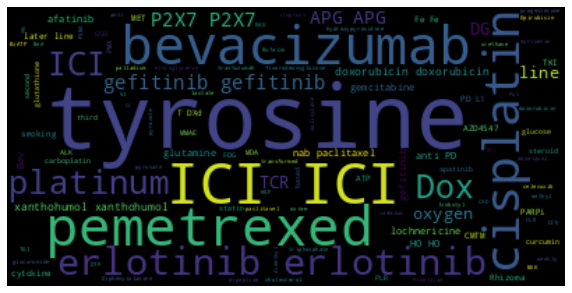

In [0]:
wordcloudplot(' '.join(chemicals))

### Using Med7 Pretrained model

In [0]:
!pip install spacy==2.3.5
!pip install https://huggingface.co/kormilitzin/en_core_med7_lg/resolve/main/en_core_med7_lg-any-py3-none-any.whl

     |███████████                     | 3.5 MB 13.4 MB/s eta 0

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 6.5 MB 7.5 MB/s 
     |████████████████████████████████| 491 kB 54.3 MB/s 
     |████████████████████████████████| 922 kB 77.6 MB/s 
     |████████████████████████████████| 56 kB 7.6 MB/s 
     |████████████████████████████████| 58 kB 8.9 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.2
    Uninstalling catalogue-1.0.2:
      Successfully uninstalled catalogue-1.0.2
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.6
    Uninstalling srsly-1.0.6:
      Successfully uninstalled srsly-1.0.6
  Attempting uninstall: smart-open
    Found existing installation: smart-open 5.1.0
    Not uninstalling smart-open at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-3b5adb06-49fc-4508-bd29-20701a99d3de
    Can't

In [0]:
import spacy
nlpmodel_med7 = spacy.load("en_core_med7_lg")
print(f"Components of the pipeline:{nlpmodel_med7.component_names}")
print(f"Named Entities target: {nlpmodel_med7.get_pipe('ner').labels}")

Components of the pipeline:['tok2vec', 'ner']
Named Entities target: ('DOSAGE', 'DRUG', 'DURATION', 'FORM', 'FREQUENCY', 'ROUTE', 'STRENGTH')


In [0]:
docx = nlpmodel_med7(alltext)
output = []
for ent in docx.ents:
    output.append({'text':ent.text,'label':ent.label_})
entity_df = spark.createDataFrame(output)
distinct_df = entity_df.dropDuplicates()
distinct_df.show()

+---------+--------------------+
|    label|                text|
+---------+--------------------+
|     DRUG|Serine-arginine p...|
|     DRUG|          crizotinib|
|     DRUG|            afatinib|
|     DRUG|           nivolumab|
|     DRUG|         osimertinib|
|     DRUG|             bufalin|
|     DRUG|           erlotinib|
|     DRUG|           docetaxel|
|FREQUENCY|                 day|
|     DRUG|   Luna phenyl-hexyl|
|     DRUG|        chemotherapy|
|     DRUG|         pralsetinib|
|   DOSAGE|       multi-peptide|
|     DRUG|          phenomenex|
|     DRUG|         amivantamab|
|     DRUG|        mobocertinib|
|     DRUG|           gefitinib|
|     DRUG|          durvalumab|
| DURATION|         for 42 days|
|     DRUG|             Bufalin|
+---------+--------------------+
only showing top 20 rows



In [0]:
from spacy import displacy
smallchunk = nlpmodel_med7(alltext[5000:10000])
displacy.render(smallchunk, style='ent',jupyter=True)

tly, great efforts have been made against RET. Selpercatinib and 
 
 pralsetinib
 DRUG 
 
, with encouraging efficacy, intracranial activity, and tolerability, were approved by the Food and Drug Administration (FDA) in 2020. The development of acquired resistance is inevitable, and a deeper exploration should be conducted. This article systematically reviewed RET gene and its biology as well as the oncogenic role in multiple cancers. Moreover, we also summarized recent advances in the treatment of RET and the mechanism of drug resistance. Among all cancer patient's lung cancer is the leading cause of death. Prognostic biomarkers continue to be investigated for the detection and stratification of lung cancer for clinical use. The DNA-dependent protein kinase is involved in mechanisms of DNA damage repair. Deregulation and overexpression of DNA-dependent protein kinase is associated with poor prognosis in various tumor entities. In this study, we investigated the expression of DNA-dependent protein kinase in relation to clinicopathological features and overall survival in patients with lung cancer. By immunohistochemistry, expression of DNA-dependent protein kinase was analyzed in 205 cases of lung cancer; 95 cases of adenocarcinoma, 83 cases of squamous cell lung carcinoma and 27 cases of small cell lung cancer and correlated with clinicopathological characteristics as well as patient's overall survival. In patients with adenocarcinoma, a significant correlation between strong expression of DNA-dependent protein kinase and worse overall survival was found. No significant association was observed in patients with squamous cell lung carcinoma and small cell lung cancer. Strong detection of DNA-dependent protein kinase expression was most evident in small cell lung cancer (81.48 %), followed by squamous cell lung carcinoma (62.65 %) and adenocarcinoma (61.05 %). In our study, expression of DNA-dependent protein kinase was associated with poor overall survival in patients with adenocarcinoma. DNA-dependent protein kinase could serve as a new prognostic biomarker. Insertions in exon 20 represent the third most common type of <i>EGFR</i> mutation following in-frame deletions in exon 19 and the point mutation L858R in exon 21. They are generally associated with primary resistance to EGFR-TKIs. Although 
 
 mobocertinib
 DRUG 
 
 and 
 
 amivantamab
 DRUG 
 
 were approved for adult patients with non-small cell lung cancer (NSCLC) harboring <i>EGFR</i> exon 20 insertion mutations, the efficacy of these two agents was rather moderate. Therefore, other more potent targeted agents are urgently needed. Here, we report a patient with advanced lung adenocarcinoma harboring an <i>EGFR</i> exon 20 insertion mutation (NM_005228: exon 20: c.2316_2321dup: p.773_774dup). After experiencing 
 
 platinum-based
 DRUG 
 
 
 
 chemotherapy
 DRUG 
 
, this patient received a combination of furmonertinib and anlotinib and achieved lasting stable disease (SD). The treatment was well tolerated, and only mild hand-foot syndrome was reported from the patient. To the best of our knowledge, this case firstly reported the encouraging efficacy of combined furmonertinib and anlotinib in an advanced lung adenocarcinoma patient with an <i>EGFR</i> exon 20 insertion mutation who was previously treated with 
 
 platinum-based
 DRUG 
 
 
 
 chemotherapy
 DRUG 
 
. In addition, we summarize the recent literature on therapies against NSCLC with <i>EGFR</i> exon 20 insertion mutations. This case might provide an alternative approach for clinical oncologists. Lung squamous cell carcinoma (LUSC) is a common respiratory malignancy and presents an increasing prevalence. Ferroptosis is a newly identified controlled cell death that has captured clinical attention worldwide. However, the ferroptosis-related lncRNA expression in LUSC and its relevance to prognosis remain elusive. Ensartinib is a novel ALK inhibitor with potent activity against a broad range of known 
 
 crizotin

###### Overall, predicted text labeled with medical entities using Med7 pretrained model

In [0]:
drugs = extract_specific_tags(nlpmodel_med7, alltext, 'DRUG')

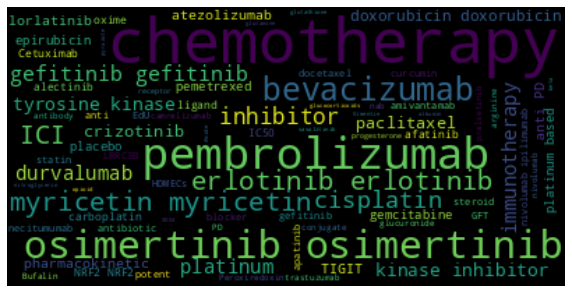

In [0]:
wordcloudplot(' '.join(drugs))

In [0]:
dur = extract_specific_tags(nlpmodel_med7, alltext, 'DURATION')

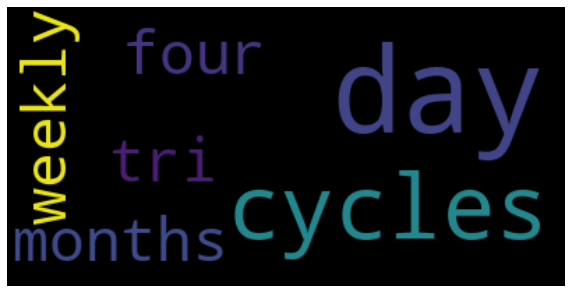

In [0]:
wordcloudplot(' '.join(dur))

The word cloud here displays the most commonly occurring medical terms, procedures, drugs, and conditions visually. This type of visualization can provide insights into the most relevant and significant medical entities in a particular field or specialty.

### Now Lets go document by document to find simialrity in research articles and cluster them using kmeans

In [0]:
a = df.collect()

In [0]:
import pandas as pd
pdf = pd.DataFrame(a)#[1][0]
def get_spacy_embeddings(text):
    doc = nlpmodel(text)
    return doc.vector


m = pdf[1].apply(lambda x: get_spacy_embeddings(x))

In [0]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import FloatType
from pyspark.ml.linalg import VectorUDT

# define function to get Spacy embeddings using udf
def get_spacy_embeddings(text):
    doc = nlpmodel(text)
    return Vectors.dense(doc.vector.tolist())

spacy_udf = udf(get_spacy_embeddings, VectorUDT())

In [0]:
m = df.withColumn("features", spacy_udf("article_abstract"))
#m.show(truncate=False)

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [0]:
m.columns

Out[139]: ['_id', 'article_abstract', 'article_authors', 'article_title', 'features']

In [0]:
kmeans = KMeans().setK(5).setSeed(1)

In [0]:
model = kmeans.fit(m.select('features'))

In [0]:
predictions = model.transform(m)

# Evaluate the clustering performance using the silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette Score:", silhouette)

# Extract the predicted cluster labels from the predictions dataframe
clusters = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

Silhouette Score: -0.006477280951838244


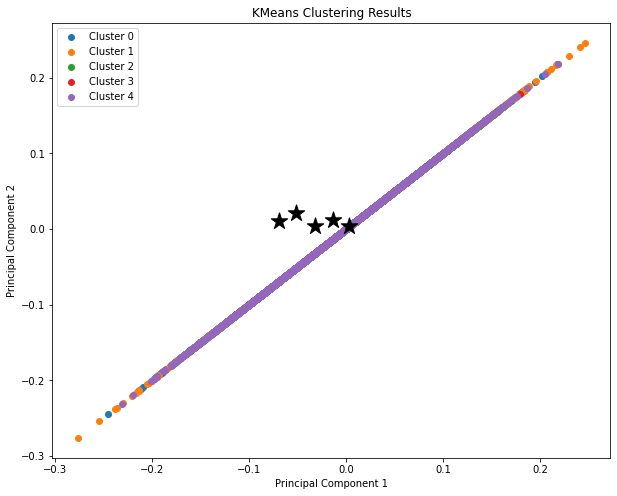

In [0]:
pca_df = model.transform(m).select("prediction", "features")
#pca_df = pca_df.rdd.map(lambda x: (x[0], x[1].toArray())).toDF(["cluster", "features"])
cluster_centers = model.clusterCenters()

fig, ax = plt.subplots(figsize=(10, 8))
for i in range(len(cluster_centers)):
    ax.scatter(pca_df.filter(pca_df.prediction == i).select("features").collect(),
               pca_df.filter(pca_df.prediction == i).select("features").collect(),
               label="Cluster " + str(i))
    ax.scatter(cluster_centers[i][0], cluster_centers[i][1], s=300, marker="*", color="black")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("KMeans Clustering Results")
ax.legend()
plt.show()

In [0]:
pca_df.show()

+----------+--------------------+
|prediction|            features|
+----------+--------------------+
|         0|[-0.0033492443617...|
|         0|[-0.0033492443617...|
|         1|[-0.0414740443229...|
|         1|[-0.0345046222209...|
|         0|[-0.0220315679907...|
|         4|[0.00173418852500...|
|         0|[-0.0046393587253...|
|         2|[-0.0319764167070...|
|         0|[-0.0710189715027...|
|         3|[-0.0693862512707...|
|         0|[-0.0503776147961...|
|         0|[-0.0612937547266...|
|         1|[-0.0397880077362...|
|         0|[-0.0066248597577...|
|         0|[-0.0650063604116...|
|         0|[-0.0380222611129...|
|         0|[-0.0656634569168...|
|         0|[-0.0549057461321...|
|         0|[-0.0734248459339...|
|         0|[-0.0289567280560...|
+----------+--------------------+
only showing top 20 rows



Further the embeddings were used to build the cluster to identify how unique research topics are being carried out. It will also be helpful for us to segregate the authors, research areas and medical treatments and finding going on. We can see that the optimal 5 clusters were defined by using Silhouette Score. But the plot is very bad, showing that more research is highly similar.